In [1]:
import pandas as pd
from finta import TA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("./bitcoin_2010-07-24_2023-08-23.csv")
df['Start']=pd.to_datetime(df['Start'])
df.set_index('Start',inplace=True)
df.sort_index(ascending=True,inplace=True)
df.drop('End',axis=1,inplace=True)
df

,Open,High,Low,Close,Volume,Market Cap
Start,,,,,,
2010-07-24,0.0545,0.0545,0.0545,0.0545,0.000000e+00,0.000000e+00
2010-07-25,0.0505,0.0505,0.0505,0.0505,0.000000e+00,0.000000e+00
2010-07-26,0.0560,0.0560,0.0560,0.0560,0.000000e+00,0.000000e+00
2010-07-27,0.0600,0.0600,0.0600,0.0600,0.000000e+00,0.000000e+00
2010-07-28,0.0589,0.0589,0.0589,0.0589,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
2023-08-18,26659.8500,26784.2300,25721.5300,26058.2600,7.032831e+10,5.115170e+11
2023-08-19,26069.2300,26253.2600,25814.2500,26090.6300,4.769626e+10,5.060530e+11
2023-08-20,26085.1800,26267.3300,26002.0300,26180.0000,3.624048e+10,5.084380e+11


In [3]:
# Get technical indicator
def get_ta(df):
    
    # Calculate ADX
    df['ADX'] = TA.ADX(df)
    
    # Calculate RSI
    df['RSI'] = TA.RSI(df)
    
    # Calculate Bollinger Bands
    bollinger_bands = TA.BBANDS(df)
    df['BollingerUpper'] = bollinger_bands['BB_UPPER']
    df['BollingerMiddle'] = bollinger_bands['BB_MIDDLE']
    df['BollingerLower'] = bollinger_bands['BB_LOWER']
    
    # Calculate EMA21
    df['EMA21'] = TA.EMA(df, 21)
    
    # Calculate SMA99
    df['EMA99'] = TA.EMA(df, 99)
    
    # Calculate EMA151
    df['EMA151'] = TA.EMA(df, 151)
    
    df.dropna(inplace=True)
    
    return df

In [4]:
def label_market(df, criteria):
    df['MarketLabel'] = 0
    indices = df.index.tolist()
    
    for i in range(len(indices)):
        current_index = indices[i]
        trendy_count = 0
        
        if df.loc[current_index, 'ADX'] > 25:
            trendy_count += 1
        
        if df.loc[current_index, 'RSI'] < 30 or df.loc[current_index, 'RSI'] > 70:
            trendy_count += 1

        if i > 0:
            previous_index = indices[i-1]
            current_width = df.loc[current_index, 'BollingerUpper'] - df.loc[current_index, 'BollingerLower']
            previous_width = df.loc[previous_index, 'BollingerUpper'] - df.loc[previous_index, 'BollingerLower']
            
            if current_width > previous_width:
                trendy_count += 1

        if trendy_count >= criteria:
            df.loc[current_index, 'MarketLabel'] = 1  # Trendy
            
    return df

In [5]:
def plot_colored_market_trends(df):
    fig, ax = plt.subplots()
    prev_price = df['Close'].iloc[0]
    prev_date = df.index[0]
    prev_label = df['MarketLabel'].iloc[0]

    for date, row in df.iterrows():
        current_price = row['Close']
        current_label = row['MarketLabel']
        
        color = 'g' if current_label == 1 else 'b'
        
        ax.plot([prev_date, date], [prev_price, current_price], color=color)
        
        prev_price = current_price
        prev_date = date
        prev_label = current_label

    ax.set_title('BTC Prices with Market Labels')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

    plt.show()

In [6]:
df = get_ta(df)
df = label_market(df,2)

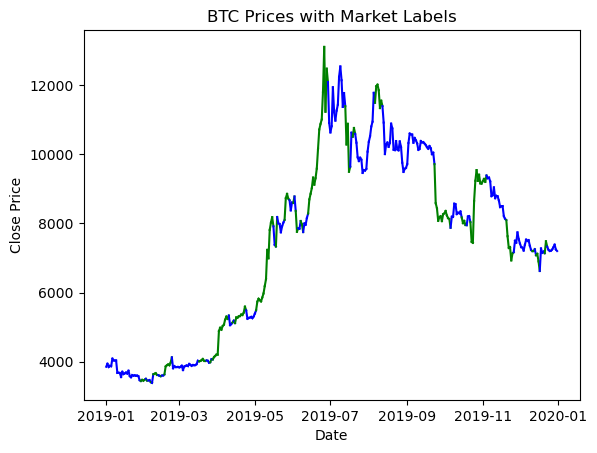

In [7]:
labeled_df = df['2019-01-01':'2019-12-31']
plot_colored_market_trends(labeled_df)

In [8]:
df['MarketLabel'].value_counts()

0    2922
1    1837
Name: MarketLabel, dtype: int64

In [9]:
X = df.drop(columns=["MarketLabel"])
y = df["MarketLabel"]

In [10]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [11]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Fit the scaler to the features training dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## SVM Model 

In [12]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()

# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
print(svm_pred)

[0 0 0 ... 0 0 1]


In [13]:
accuracy_score(y_test, svm_pred)

0.826890756302521

In [14]:
# Generate a confusion matrix for the model

confusion_matrix(y_test, svm_pred)

array([[714,  28],
       [178, 270]], dtype=int64)

In [15]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       742
           1       0.91      0.60      0.72       448

    accuracy                           0.83      1190
   macro avg       0.85      0.78      0.80      1190
weighted avg       0.84      0.83      0.82      1190



# GB Model 

In [16]:
# Initialize Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model
gb_clf.fit(X_train_scaled, y_train)

# Predict the labels
y_pred = gb_clf.predict(X_test_scaled)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       742
           1       0.90      0.71      0.79       448

    accuracy                           0.86      1190
   macro avg       0.87      0.83      0.84      1190
weighted avg       0.86      0.86      0.86      1190



## Logistics Regression

In [17]:
lg_model = LogisticRegression(random_state=1)  

# Fit the model using training data
lg_model.fit(X_train_scaled,y_train)

LogisticRegression(random_state=1)

In [18]:
lg_predictions = lg_model.predict(X_test_scaled)

In [19]:
accuracy_score(y_test, lg_predictions)

0.692436974789916

In [20]:
confusion_matrix(y_test, lg_predictions)

array([[629, 113],
       [253, 195]], dtype=int64)

In [21]:
print(classification_report(y_test, lg_predictions))

              precision    recall  f1-score   support

           0       0.71      0.85      0.77       742
           1       0.63      0.44      0.52       448

    accuracy                           0.69      1190
   macro avg       0.67      0.64      0.65      1190
weighted avg       0.68      0.69      0.68      1190



## Random Forest 

In [22]:
rf_model = RandomForestClassifier(random_state=1)

# Fit the model using training data
rf_model.fit(X_train_scaled,y_train)

RandomForestClassifier(random_state=1)

In [23]:
rf_predictions = rf_model.predict(X_test_scaled)

In [24]:
accuracy_score(y_test, rf_predictions)

0.8899159663865546

In [25]:
confusion_matrix(y_test, rf_predictions)

array([[690,  52],
       [ 79, 369]], dtype=int64)

In [26]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       742
           1       0.88      0.82      0.85       448

    accuracy                           0.89      1190
   macro avg       0.89      0.88      0.88      1190
weighted avg       0.89      0.89      0.89      1190



## LSTM

In [27]:
lstm = Sequential()

# Creating the first hidden layer
lstm.add(LSTM(units = 70, return_sequences = True, input_shape = (X_train_scaled.shape[1],1)))
lstm.add(Dropout(0.2))

# Creating the second hidden layer
lstm.add(LSTM(units = 60, return_sequences = True, activation = 'relu'))
lstm.add(Dropout(0.1))

# Creating the third hidden layer
lstm.add(LSTM(units = 60, return_sequences = True, activation = 'relu'))
lstm.add(Dropout(0.1))

# Creating the fourth hidden layer
lstm.add(LSTM(units = 60, activation = 'relu'))
lstm.add(Dropout(0.1))

# Creating the output layer to the model 
lstm.add(Dense(units = 1, activation= 'sigmoid'))


In [28]:
# Display the LSTM model summary
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 70)            20160     
                                                                 
 dropout (Dropout)           (None, 14, 70)            0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 60)            31440     
                                                                 
 dropout_1 (Dropout)         (None, 14, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 14, 60)            29040     
                                                                 
 dropout_2 (Dropout)         (None, 14, 60)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60)                2

In [29]:
# Compile the model
lstm.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])


In [30]:
# Fit the model with the scaled train data and corresponding lables with 50 epochs
lstm.fit(X_train_scaled, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
112/112 [==============================] - 10s 40ms/step - loss: 0.2321 - accuracy: 0.6086
Epoch 2/50
112/112 [==============================] - 4s 39ms/step - loss: 0.2218 - accuracy: 0.6568
Epoch 3/50
112/112 [==============================] - 5s 42ms/step - loss: 0.2027 - accuracy: 0.6988
Epoch 4/50
112/112 [==============================] - 5s 43ms/step - loss: 0.1986 - accuracy: 0.7010
Epoch 5/50
112/112 [==============================] - 4s 37ms/step - loss: 0.2011 - accuracy: 0.7064
Epoch 6/50
112/112 [==============================] - 4s 36ms/step - loss: 0.1965 - accuracy: 0.7061
Epoch 7/50
112/112 [==============================] - 4s 36ms/step - loss: 0.1971 - accuracy: 0.7061
Epoch 8/50
112/112 [==============================] - 4s 33ms/step - loss: 0.1942 - accuracy: 0.7111
Epoch 9/50
112/112 [==============================] - 5s 41ms/step - loss: 0.1897 - accuracy: 0.7249
Epoch 10/50
112/112 [==============================] - 4s 39ms/step - loss: 0.1885 - accur

In [32]:
# Display the prdictions by the model on the test data
pred = lstm.predict(X_test_scaled)

# convert predictions to binary and required data structure
lstm_pred= np.where(pred > 0.5, 1, 0).ravel()
lstm_pred

38/38 [==============================] - 1s 16ms/step


array([0, 0, 0, ..., 0, 0, 1])

In [33]:
# Obtain the classification report of the predictions
print(classification_report(y_test, lstm_pred))


              precision    recall  f1-score   support

           0       0.81      0.93      0.87       742
           1       0.85      0.63      0.72       448

    accuracy                           0.82      1190
   macro avg       0.83      0.78      0.80      1190
weighted avg       0.82      0.82      0.81      1190



## Neural Networks 



In [34]:
# Build the neural network model
nn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = nn_model.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/50
90/90 [==============================] - 1s 6ms/step - loss: 0.5955 - accuracy: 0.6799 - val_loss: 0.5318 - val_accuracy: 0.7143
Epoch 2/50
90/90 [==============================] - 0s 4ms/step - loss: 0.5239 - accuracy: 0.7180 - val_loss: 0.4794 - val_accuracy: 0.7451
Epoch 3/50
90/90 [==============================] - 0s 4ms/step - loss: 0.4743 - accuracy: 0.7520 - val_loss: 0.4404 - val_accuracy: 0.7745
Epoch 4/50
90/90 [==============================] - 0s 4ms/step - loss: 0.4402 - accuracy: 0.7755 - val_loss: 0.4075 - val_accuracy: 0.8039
Epoch 5/50
90/90 [==============================] - 0s 4ms/step - loss: 0.4056 - accuracy: 0.7975 - val_loss: 0.3836 - val_accuracy: 0.8081
Epoch 6/50
90/90 [==============================] - 0s 4ms/step - loss: 0.3964 - accuracy: 0.8018 - val_loss: 0.3827 - val_accuracy: 0.8151
Epoch 7/50
90/90 [==============================] - 0s 4ms/step - loss: 0.3893 - accuracy: 0.8074 - val_loss: 0.3738 - val_accuracy: 0.8123
Epoch 8/50
90/90 [==

## Backtesting Strategy

In [35]:
#add backtesting with strategy 
df = pd.read_csv("./bitcoin_2010-07-24_2023-08-23.csv")
df['Start']=pd.to_datetime(df['Start'])
df.set_index('Start',inplace=True)
df.sort_index(ascending=True,inplace=True)
df.drop('End',axis=1,inplace=True)

df = get_ta(df)
df = label_market(df,2)

X = df.drop(columns=["MarketLabel"])
y = df["MarketLabel"]

split_date = pd.Timestamp('2022-01-01')
validation_date = pd.Timestamp('2023-07-01')
# Training data up to end of 2021
X_train = X.loc[:split_date]
y_train = y.loc[:split_date]

# Test data starting from 2022 to 2023-July
X_test = X.loc[split_date:validation_date]
y_test = y.loc[split_date:validation_date]

X_validation = X.loc[validation_date:]
y_validation = y.loc[validation_date:]

In [36]:
def plot_colored_market_trends_1(df,predictions):
    fig, ax = plt.subplots()
    prev_price = df['Close'].iloc[0]
    prev_date = df.index[0]
    prev_label = df['MarketLabel'].iloc[0]

    for i, (date, row) in enumerate(df.iterrows()):
        current_price = row['Close']
        current_label = predictions[i]
        
        color = 'g' if current_label == 1 else 'b'
        
        ax.plot([prev_date, date], [prev_price, current_price], color=color)
        
        prev_price = current_price
        prev_date = date
        prev_label = current_label

    ax.set_title('BTC Prices with Market Labels')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

    plt.show()

#### Validation for SVM Model 

In [37]:

# 1. Scale the validation data

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_validation_scaled = X_scaler.transform(X_validation)

# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
svm_model = svm_model.fit(X_train_scaled, y_train)

# 2. Make predictions on the validation data
svm_validation_pred = svm_model.predict(X_validation_scaled)

# 3. Evaluate the model's performance
print("Accuracy on validation data: ", accuracy_score(y_validation, svm_validation_pred))
print("Confusion Matrix on validation data: \n", confusion_matrix(y_validation, svm_validation_pred))
print("Classification Report on validation data: \n", classification_report(y_validation, svm_validation_pred))


Accuracy on validation data:  0.6792452830188679
Confusion Matrix on validation data: 
 [[29  1]
 [16  7]]
Classification Report on validation data: 
               precision    recall  f1-score   support

           0       0.64      0.97      0.77        30
           1       0.88      0.30      0.45        23

    accuracy                           0.68        53
   macro avg       0.76      0.64      0.61        53
weighted avg       0.74      0.68      0.63        53



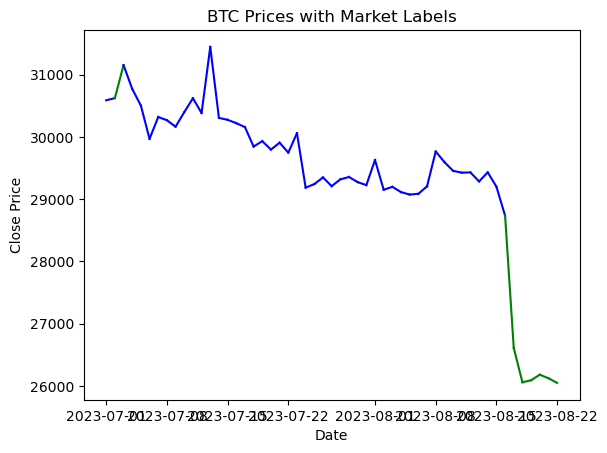

In [38]:
#validation plot for svm
plot_colored_market_trends_1(df['2023-07-01':],svm_validation_pred)

#### Validation for GB Model 

In [39]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model = gb_model.fit(X_train_scaled, y_train)
gb_validation_pred = gb_model.predict(X_validation_scaled)

print("Accuracy on validation data: ", accuracy_score(y_validation, gb_validation_pred))
print("Confusion Matrix on validation data: \n", confusion_matrix(y_validation, gb_validation_pred))
print("Classification Report on validation data: \n", classification_report(y_validation, gb_validation_pred))


Accuracy on validation data:  0.6792452830188679
Confusion Matrix on validation data: 
 [[28  2]
 [15  8]]
Classification Report on validation data: 
               precision    recall  f1-score   support

           0       0.65      0.93      0.77        30
           1       0.80      0.35      0.48        23

    accuracy                           0.68        53
   macro avg       0.73      0.64      0.63        53
weighted avg       0.72      0.68      0.64        53



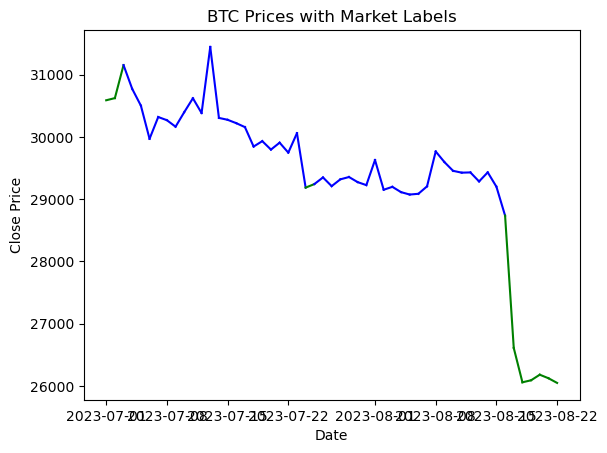

In [40]:
#validation plot for gb model
plot_colored_market_trends_1(df['2023-07-01':],gb_validation_pred)

#### Validation for Logistics Regression 

In [41]:
lg_model = LogisticRegression(random_state=1) 
lg_model = lg_model.fit(X_train_scaled, y_train)
lg_validation_pred = lg_model.predict(X_validation_scaled)

print("Accuracy on validation data: ", accuracy_score(y_validation, lg_validation_pred))
print("Confusion Matrix on validation data: \n", confusion_matrix(y_validation, lg_validation_pred))
print("Classification Report on validation data: \n", classification_report(y_validation, lg_validation_pred))

Accuracy on validation data:  0.5471698113207547
Confusion Matrix on validation data: 
 [[27  3]
 [21  2]]
Classification Report on validation data: 
               precision    recall  f1-score   support

           0       0.56      0.90      0.69        30
           1       0.40      0.09      0.14        23

    accuracy                           0.55        53
   macro avg       0.48      0.49      0.42        53
weighted avg       0.49      0.55      0.45        53



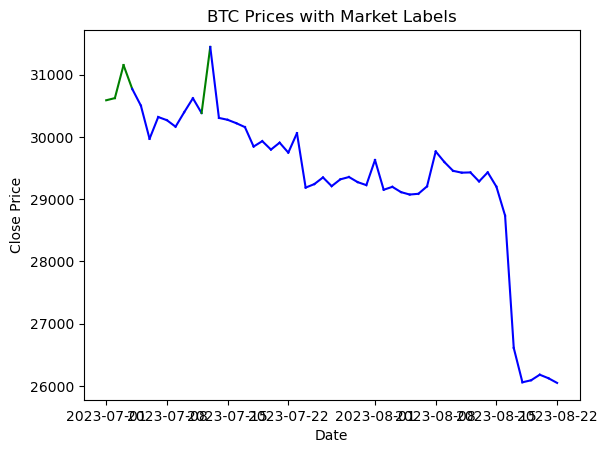

In [42]:
#validation plot for gb model
plot_colored_market_trends_1(df['2023-07-01':],lg_validation_pred)

#### Validation for Random Forest 

In [43]:
rf_model = RandomForestClassifier(random_state=1)
rf_model = rf_model.fit(X_train_scaled, y_train)
rf_validation_pred = rf_model.predict(X_validation_scaled)

print("Accuracy on validation data: ", accuracy_score(y_validation, rf_validation_pred))
print("Confusion Matrix on validation data: \n", confusion_matrix(y_validation, rf_validation_pred))
print("Classification Report on validation data: \n", classification_report(y_validation, rf_validation_pred))

Accuracy on validation data:  0.8490566037735849
Confusion Matrix on validation data: 
 [[27  3]
 [ 5 18]]
Classification Report on validation data: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.86      0.78      0.82        23

    accuracy                           0.85        53
   macro avg       0.85      0.84      0.84        53
weighted avg       0.85      0.85      0.85        53



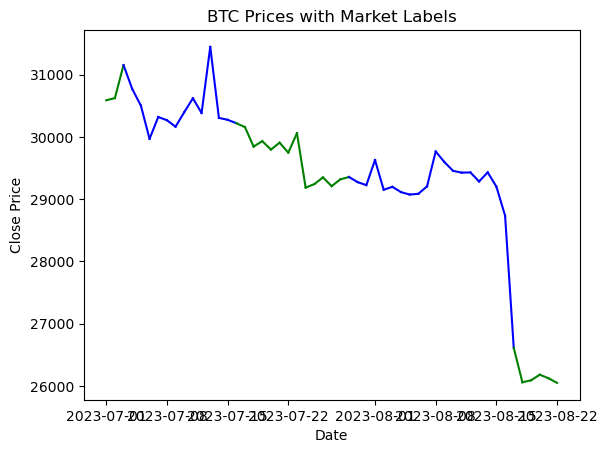

In [44]:
#validation plot for rf model
plot_colored_market_trends_1(df['2023-07-01':],rf_validation_pred)

#### Validation of LSTM

In [45]:
lstm_validation_pred = gb_model.predict(X_validation_scaled)

print("Accuracy on validation data: ", accuracy_score(y_validation, rf_validation_pred))
print("Confusion Matrix on validation data: \n", confusion_matrix(y_validation, rf_validation_pred))
print("Classification Report on validation data: \n", classification_report(y_validation, rf_validation_pred))

Accuracy on validation data:  0.8490566037735849
Confusion Matrix on validation data: 
 [[27  3]
 [ 5 18]]
Classification Report on validation data: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.86      0.78      0.82        23

    accuracy                           0.85        53
   macro avg       0.85      0.84      0.84        53
weighted avg       0.85      0.85      0.85        53



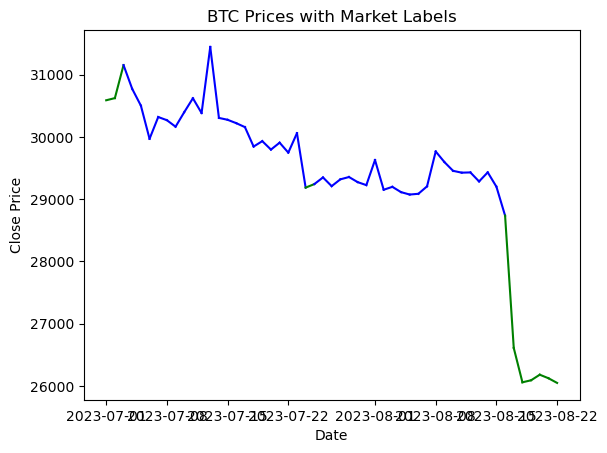

In [46]:
#validation plot for rf model
plot_colored_market_trends_1(df['2023-07-01':],lstm_validation_pred)

#### Validation of Neural Network

In [47]:
nn_validation_pred = nn_model.predict(X_validation_scaled)

print("Accuracy on validation data: ", accuracy_score(y_validation, rf_validation_pred))
print("Confusion Matrix on validation data: \n", confusion_matrix(y_validation, rf_validation_pred))
print("Classification Report on validation data: \n", classification_report(y_validation, rf_validation_pred))

2/2 [==============================] - 0s 4ms/step
Accuracy on validation data:  0.8490566037735849
Confusion Matrix on validation data: 
 [[27  3]
 [ 5 18]]
Classification Report on validation data: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.86      0.78      0.82        23

    accuracy                           0.85        53
   macro avg       0.85      0.84      0.84        53
weighted avg       0.85      0.85      0.85        53



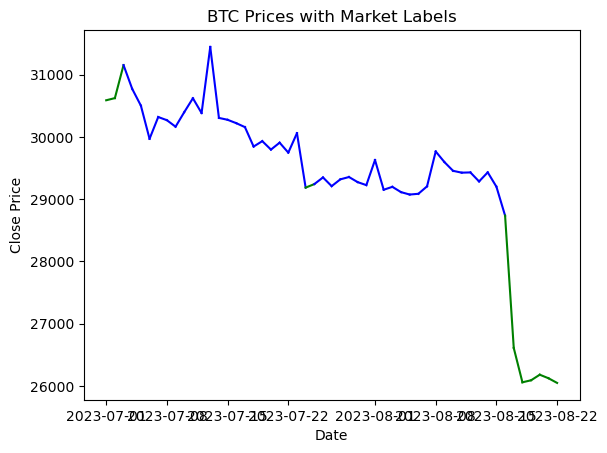

In [48]:
#validation plot for Neural Network model
plot_colored_market_trends_1(df['2023-07-01':],lstm_validation_pred)